<a href="https://colab.research.google.com/github/hessrafael/mvp_rafael_hess_titanic_class/blob/main/MVP_Rafael_Hess_Titanic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projeto MVP para prever se um passageiro do Titanic sobreviveria ou não com base em seus atributos**

Pós-Graduação em Eng. de Software - PUCRio, Dezembro 2023

Autoria: Rafael Hess Almaleh


O dataset escolhido é o dataset "Titanic", contendo a lista de passageiros, seus atributos e apontando se o passageiro morreu ou sobreviveu.

O objetivo do projeto é prever (i.e classificar) se um passageiro sobreviveu ou faleceu no acidente com base nos seus atributos.

A lista de atributos presente é a seguinte:



```
|| Variavel || Definição || Chave ||
| survival | Sobreviveu | 0 = Não, 1 = Sim |
| pclass | Classe da acomodação | 1 = 1ª, 2 = 2ª, 3 = 3ª |
| sex | Sexo | male = homem, female = mulher |
| Age | Idade em anos |  |
| sibsp | # de irmãos ou esposas a bordo do Titanic |  |
| parch | # of pais ou filhos a bordo do Titanic |  |
| ticket | Numero do bilhete |  |
| fare | Preço do bilhete |  |
| cabin | Número da cabine |  |
| embarked | Porto de embarque | C = Cherbourg, Q = Queenstown, S = Southampton |
```






## Primeiro, realizamos os imports necessários para funcionamento

In [26]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

## Realizando a carga dos dados

In [27]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/hessrafael/mvp_rafael_hess_titanic_class/main/train.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Criando o Golden Dataset como um subconjunto do dataset original

In [28]:
# Reprodutibilidade
golden_seed = 7

# Copiar o DataFrame original para garantir que não modifique o dataset original
golden_dataset = dataset.copy()

# Extrair 10% das linhas para o golden_dataset
golden_dataset = golden_dataset.sample(frac=0.1, random_state=golden_seed)

# Remover as linhas presentes no golden_dataset do dataset original
dataset = dataset.drop(golden_dataset.index)

# Mostra as primeiras linhas do golden_dataset
golden_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
725,726,0,3,"Oreskovic, Mr. Luka",male,20.0,0,0,315094,8.6625,NaN,S
861,862,0,2,"Giles, Mr. Frederick Edward",male,21.0,1,0,28134,11.5000,NaN,S
528,529,0,3,"Salonen, Mr. Johan Werner",male,39.0,0,0,3101296,7.9250,NaN,S
46,47,0,3,"Lennon, Mr. Denis",male,NaN,1,0,370371,15.5000,NaN,Q
627,628,1,1,"Longley, Miss. Gretchen Fiske",female,21.0,0,0,13502,77.9583,D9,S


## Preprocessamento para limpeza e completude de dados

In [29]:
# Verificamos a quantidade total de registros e alguns parametros
nr_linhas = dataset.count(0)['PassengerId']
print(nr_linhas)

802


In [30]:
# Verificamos a quantidade de valores NULL em cada coluna e o quanto representa no conjunto total
nome_colunas = dataset.columns
for coluna in nome_colunas:
    ocorrencias = dataset[coluna].isnull().sum()
    percentual = ocorrencias/nr_linhas
    print(coluna + ' - ' + str(ocorrencias) + ' - ' + str(percentual))

PassengerId - 0 - 0.0
Survived - 0 - 0.0
Pclass - 0 - 0.0
Name - 0 - 0.0
Sex - 0 - 0.0
Age - 162 - 0.20199501246882792
SibSp - 0 - 0.0
Parch - 0 - 0.0
Ticket - 0 - 0.0
Fare - 0 - 0.0
Cabin - 611 - 0.7618453865336658
Embarked - 0 - 0.0


In [31]:
# Podemos remover a coluna "Cabin" pois ela está com a maioria dos dados vazios e não contribui para o sistema
dataset = dataset.drop(columns=['Cabin'])
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [32]:
# Podemos remover PassengerId e Ticket pois eles não trazem relações com o fato de alguem sobreviver ou não
dataset = dataset.drop(columns=['PassengerId','Ticket'])
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [33]:
# Podemos remover o campo "Name", partindo do princípio que o nome não tem relação com a sobrevivência
'''
Além disso, no nome constam o título da pessoa, como 'Mr', 'Miss', etc. Esses títulos tem correlação com a
coluna "Sex" e com "Age", dado que uma "Miss", por exemplo, é uma mulher de baixa idade, e uma Mrs é uma mulher
de idade mais elevada
'''
dataset = dataset.drop(columns=['Name'])
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [34]:
# Temos 2 campos com "Embarked" vazio. Vamos completá-lo com o valor mais frequente
val_embarked = dataset['Embarked'].value_counts()
val_embarked.head()
dataset['Embarked'] = dataset['Embarked'].fillna(val_embarked.index[0])

# Verificamos a quantidade de valores NULL em Embarked
ocorrencias = dataset['Embarked'].isnull().sum()
print(coluna + ' - ' + str(ocorrencias) )

Embarked - 0


In [35]:
# Vamos mapear os campos String para Int
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})
dataset['Embarked'] = dataset['Embarked'].map({'C':0, 'Q':1, 'S':2})
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2
1,1,1,1,38.0,1,0,71.2833,0
2,1,3,1,26.0,0,0,7.9250,2
3,1,1,1,35.0,1,0,53.1000,2
4,0,3,0,35.0,0,0,8.0500,2


<Axes: >

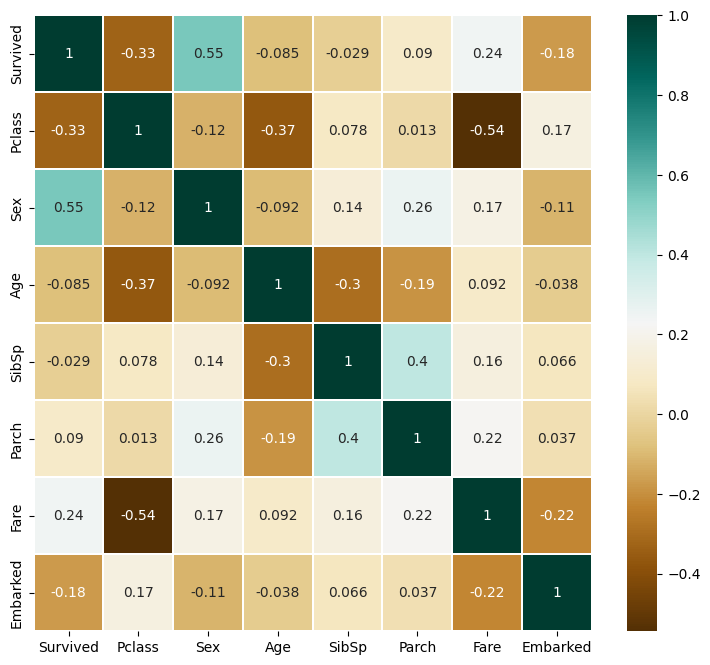

In [36]:
# Temos que preencher as idades faltantes

# Para isso, precisamos ver com quais parâmetros a idade tem correlação, para então fazermos uma média considerando o grupo
correlacao = dataset.corr()
plt.figure(figsize=(9, 8))
sns.heatmap(data = correlacao,cmap='BrBG', annot=True, linewidths=0.2)

In [37]:
# Vemos que a idade tem uma correlação forte com a classe e a quantidade de membros da família (sibsp e parch)
# Vamos completar a idade das pessoas faltantes fazendo a média com base em sibsp, parch e pclass

indices_null_age = dataset[dataset['Age'].isnull()].index

for indice in indices_null_age:
  idade_prevista = dataset['Age'][((dataset.SibSp == dataset.loc[indice]["SibSp"]) & (dataset.Parch == dataset.loc[indice]["Parch"]) & (dataset.Pclass == dataset.loc[indice]["Pclass"]))].mean()

  # Caso não tenha encontrado uma pessoa similar
  if np.isnan(idade_prevista):
    # Calcula a media com base na Classe (maior correlação)
    idade_prevista = dataset['Age'][(dataset.Pclass == dataset.loc[indice]["Pclass"])].mean()

    # Caso ainda não tenha encontrado uma pessoa similar
    if np.isnan(idade_prevista):
      # Calcula a media com base no dataset completo
      idade_prevista = dataset['Age'].mean()

  # Escreve a idade do registro originalmente null
  dataset['Age'].loc[indice] = idade_prevista

# Confere que não há nenhuma coluna com null
dataset.isnull().sum()

# Fim do pre-processamento

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [38]:
print(dataset)

     Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0           0       3    0  22.0      1      0   7.2500         2
1           1       1    1  38.0      1      0  71.2833         0
2           1       3    1  26.0      0      0   7.9250         2
3           1       1    1  35.0      1      0  53.1000         2
4           0       3    0  35.0      0      0   8.0500         2
..        ...     ...  ...   ...    ...    ...      ...       ...
885         0       3    1  39.0      0      5  29.1250         1
886         0       2    0  27.0      0      0  13.0000         2
887         1       1    1  19.0      0      0  30.0000         2
888         0       3    1  13.5      1      2  23.4500         2
889         1       1    0  26.0      0      0  30.0000         0

[802 rows x 8 columns]


## Separando em conjunto teste e treinamento


In [39]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,1:]
y = array[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação do modelo

KNN: 0.705168 (0.046432)
CART: 0.745673 (0.039140)
NB: 0.778582 (0.033098)
SVM: 0.663125 (0.041641)


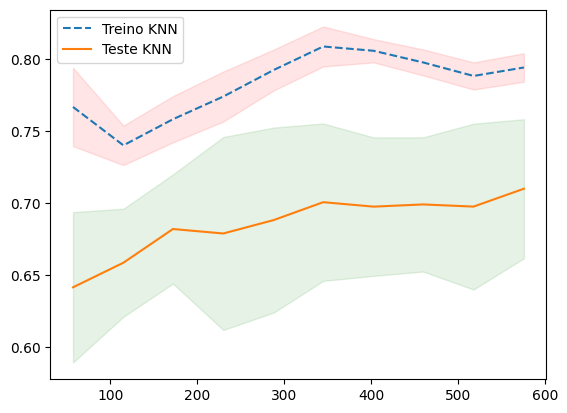

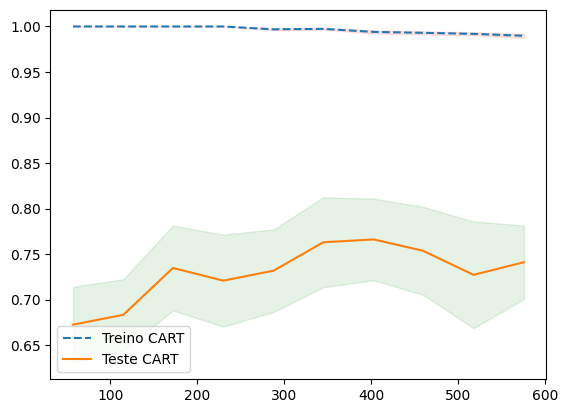

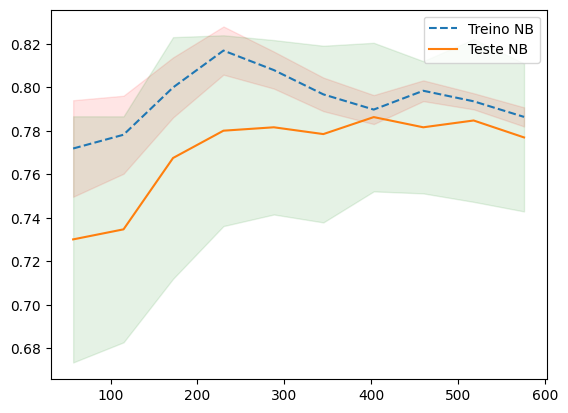

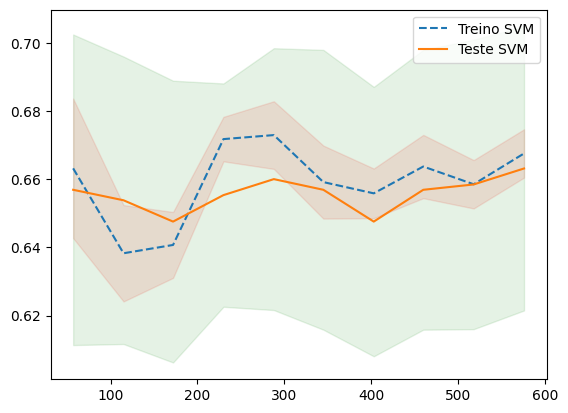

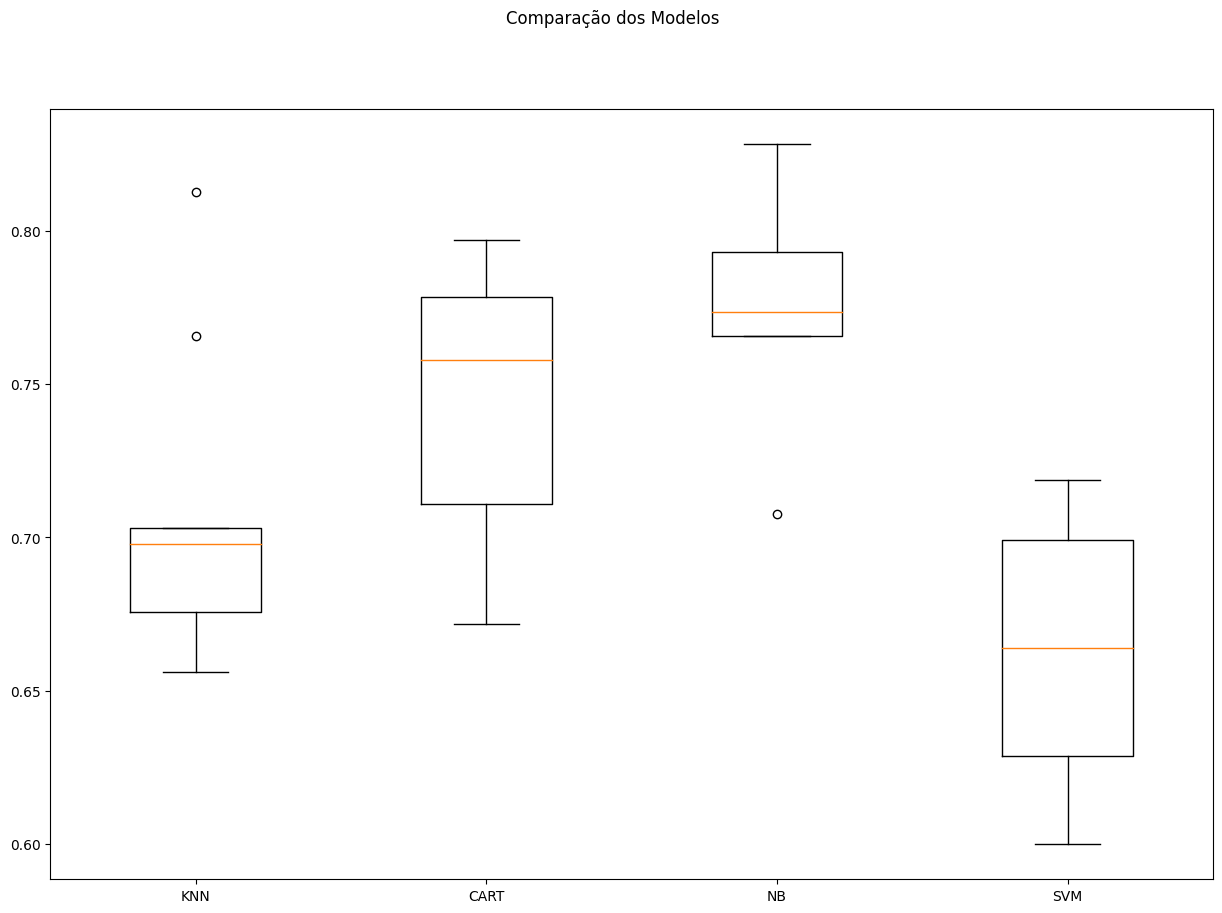

In [40]:
# Função para plotar a curva de aprendizado
def plot_learning_curve(model, X, y, scoring, cv, label_train='Treino', label_test='Teste'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(
        train_sizes,
        train_scores_mean,
        label=label_train,
        linestyle='--',
    )
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.plot(
        train_sizes,
        test_scores_mean,
        label=label_test,
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    # Plotar a curva de aprendizado para cada modelo
    plt.figure()
    plot_learning_curve(model, X_train, y_train, scoring=scoring, cv=kfold, label_train = 'Treino ' + name,label_test = 'Teste ' + name)
    plt.legend(loc="best")

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.705 (0.046)
CART-orig: 0.746 (0.039)
NB-orig: 0.779 (0.033)
SVM-orig: 0.663 (0.042)
KNN-padr: 0.793 (0.037)
CART-padr: 0.744 (0.053)
NB-padr: 0.779 (0.033)
SVM-padr: 0.816 (0.034)
KNN-norm: 0.791 (0.033)
CART-norm: 0.735 (0.043)
NB-norm: 0.779 (0.033)
SVM-norm: 0.796 (0.037)


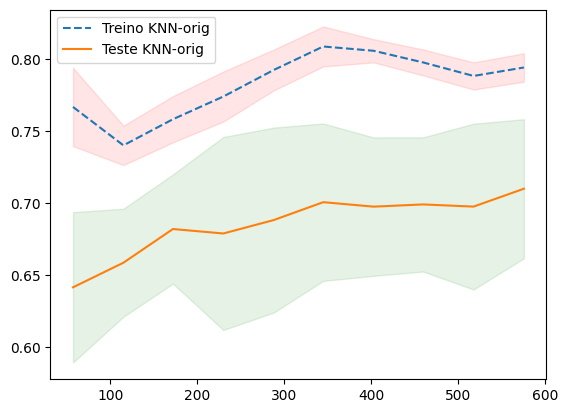

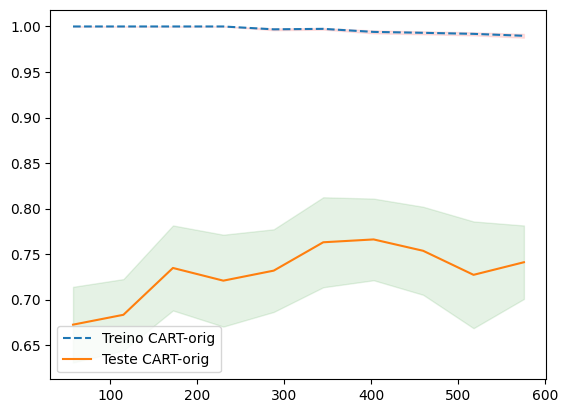

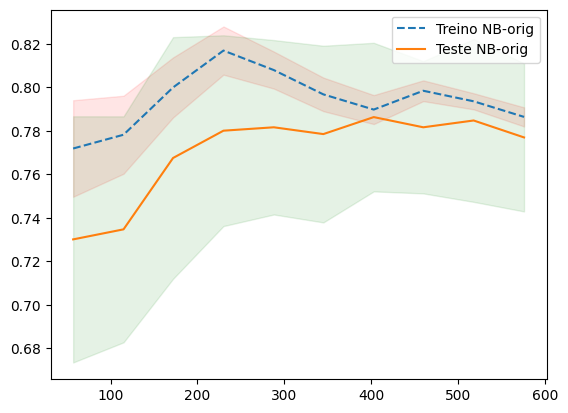

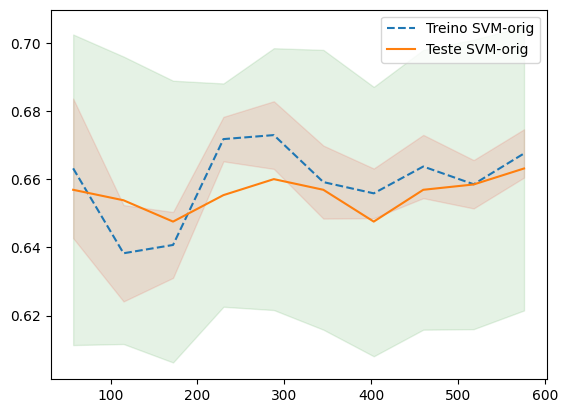

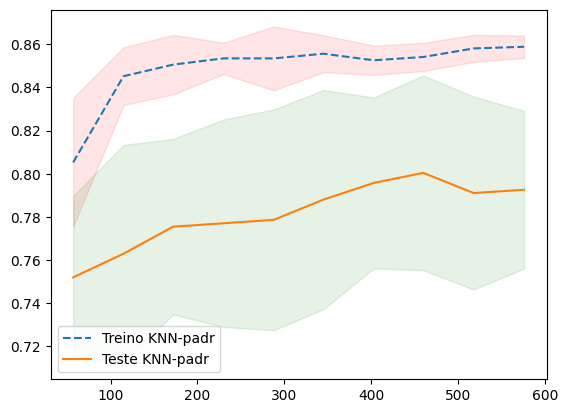

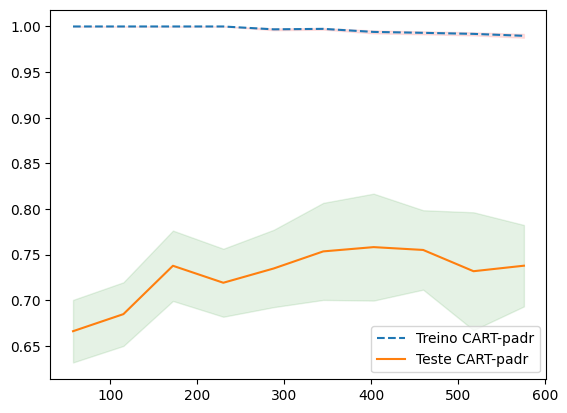

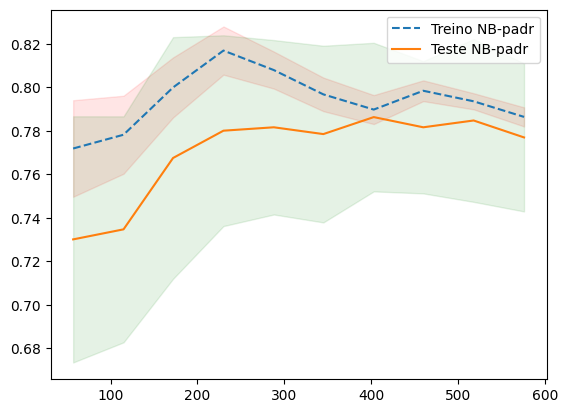

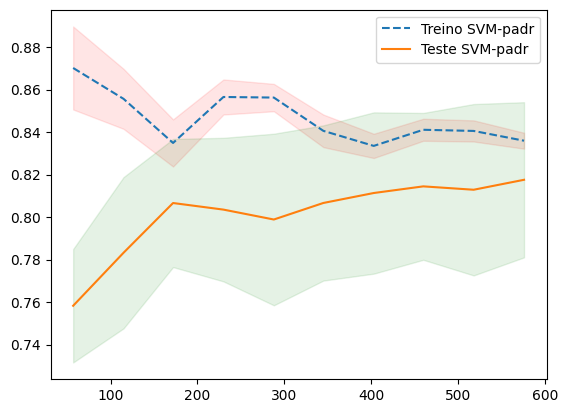

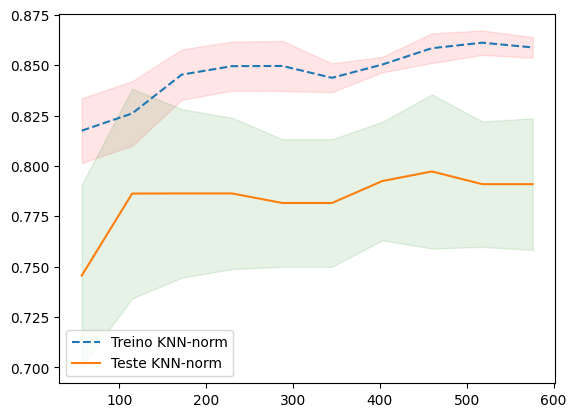

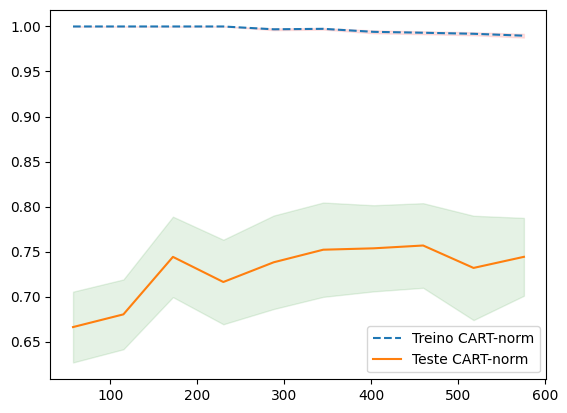

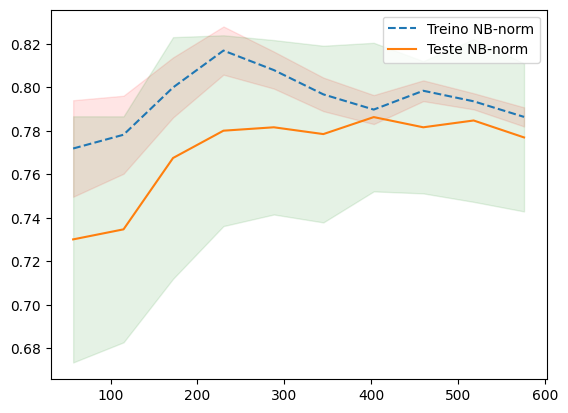

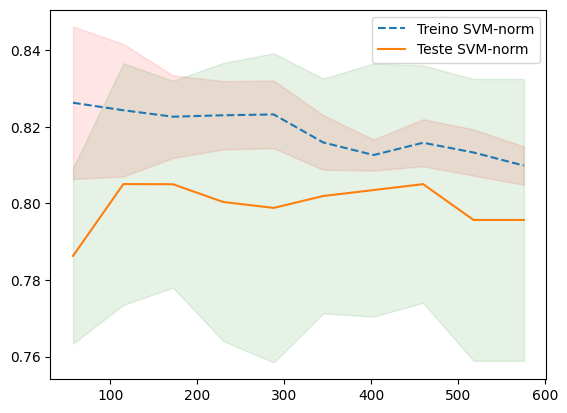

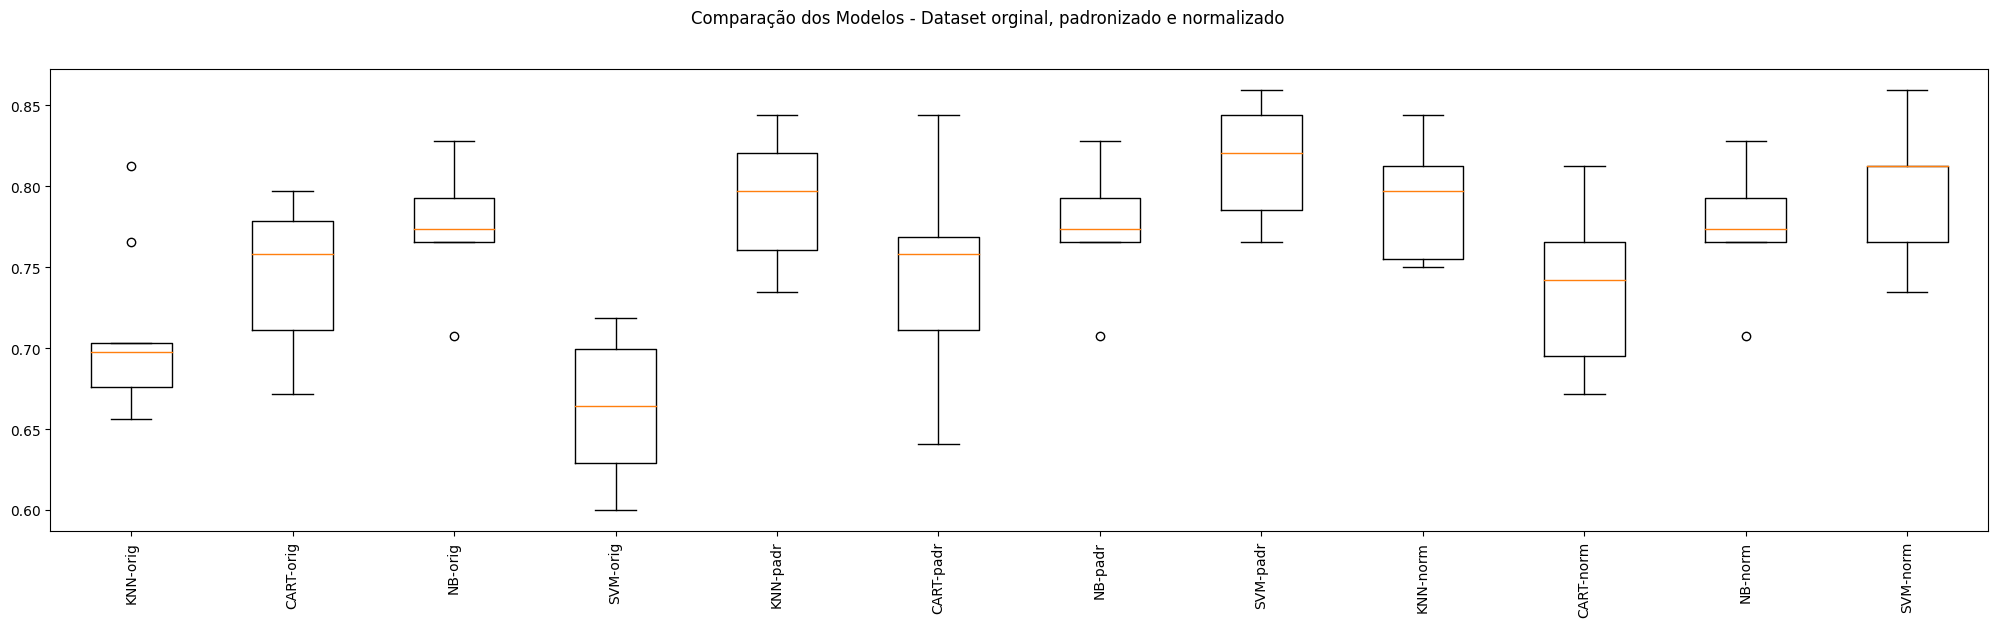

In [41]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)
    # Plotar a curva de aprendizado para cada modelo
    plt.figure()
    plot_learning_curve(model, X_train, y_train, scoring=scoring, cv=kfold, label_train = 'Treino ' + name,label_test = 'Teste ' + name)
    plt.legend(loc="best")

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Otimização Hiperparametros

In [42]:
# SVM-Padr parece ter o melhor desempenho, vamos otimizar seus hiperparametros

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

# Especificando os parâmetros a serem testados
param_grid = {'SVM__C':[1,10,100]}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    print(name)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=scoring, cv=kfold,n_iter=4, verbose=4)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))



svm-orig
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END .........................SVM__C=1;, score=0.600 total time=   0.0s
[CV 2/10] END .........................SVM__C=1;, score=0.609 total time=   0.0s
[CV 3/10] END .........................SVM__C=1;, score=0.703 total time=   0.0s
[CV 4/10] END .........................SVM__C=1;, score=0.719 total time=   0.0s
[CV 5/10] END .........................SVM__C=1;, score=0.719 total time=   0.0s
[CV 6/10] END .........................SVM__C=1;, score=0.688 total time=   0.0s
[CV 7/10] END .........................SVM__C=1;, score=0.656 total time=   0.0s
[CV 8/10] END .........................SVM__C=1;, score=0.672 total time=   0.0s
[CV 9/10] END .........................SVM__C=1;, score=0.625 total time=   0.0s
[CV 10/10] END ........................SVM__C=1;, score=0.641 total time=   0.0s
[CV 1/10] END ........................SVM__C=10;, score=0.692 total time=   0.0s
[CV 2/10] END ........................S

# Finalização do Modelo

In [43]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = SVC(C=1)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.8571428571428571


In [44]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

SVC(C=1)

In [45]:
# Exportando o modelo
filename = 'modelo_final.pkl'
pickle.dump(model, open(filename, 'wb'))

In [46]:
# Exportando o scaler
filename = 'scaler.pkl'
pickle.dump(scaler, open(filename, 'wb'))

In [47]:
# Exportando o golden_dataset
golden_dataset.to_csv('golden_dataset.csv', index=False)

APAGAR BLOCO DAQUI PARA BAIXO

In [48]:
golden_dataset = golden_dataset.drop(columns=['Name','Cabin','PassengerId','Ticket'])
golden_dataset


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
725,0,3,male,20.0,0,0,8.6625,S
861,0,2,male,21.0,1,0,11.5000,S
528,0,3,male,39.0,0,0,7.9250,S
46,0,3,male,NaN,1,0,15.5000,Q
627,1,1,female,21.0,0,0,77.9583,S
...,...,...,...,...,...,...,...,...
829,1,1,female,62.0,0,0,80.0000,NaN
365,0,3,male,30.0,0,0,7.2500,S
620,0,3,male,27.0,1,0,14.4542,C
109,1,3,female,NaN,1,0,24.1500,Q


In [49]:
golden_dataset.isnull().sum()

Survived     0
Pclass       0
Sex          0
Age         15
SibSp        0
Parch        0
Fare         0
Embarked     2
dtype: int64

In [50]:
print(X_test)
print(y_test)
print(predictions)

[[ 1.      1.     35.1875 ...  1.     55.      2.    ]
 [ 3.      0.     29.     ...  0.      9.5     2.    ]
 [ 2.      0.     28.     ...  1.     33.      2.    ]
 ...
 [ 3.      0.     16.     ...  3.     34.375   2.    ]
 [ 2.      1.     19.     ...  0.     26.      2.    ]
 [ 1.      1.     39.     ...  0.     55.9     2.    ]]
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1.

In [51]:
n = 33
print(X_test[n])
print(y_test[n])
print(predictions[n])

[ 3.    0.   24.    0.    0.    8.05  2.  ]
0.0
0.0


In [52]:
for n in range(0,len(X_test)):
  if X_test[n][1] == 0 and y_test[n] == 1:
    print('-----')
    print(n)
    print(predictions[n])

-----
1
0.0
-----
11
0.0
-----
16
0.0
-----
23
0.0
-----
45
1.0
-----
58
1.0
-----
78
0.0
-----
80
1.0
-----
98
0.0
-----
102
0.0
-----
119
0.0
-----
123
0.0
-----
133
0.0
-----
134
0.0
-----
150
1.0
